<a href="https://colab.research.google.com/github/Amelet/DeepLearning_TensorFLow/blob/main/05_transfer_learning_in_TF_partII_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TF, part II: Fine Puning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.image as mpimg
import os
import random
import matplotlib.pyplot as plt
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-08-03 12:37:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-03 12:37:45 (86.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
!nvidia-smi

Fri Aug  4 09:04:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-03 12:33:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-03 12:33:23 (68.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Load Data

In [ ]:
# 10% of food dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data('10_food_classes_10_percent.zip')
walk_through_dir('10_food_classes_10_percent')

--2023-08-03 12:33:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.114.128, 142.250.1.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.114.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   100MB/s    in 1.6s    

2023-08-03 12:33:27 (100 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in

# Train/test

In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
class_labels = train_data_10_percent.class_names
test_data.class_names

# Model 0: Building a transfer learning model, Feature Extraction.
Using Keras Functional API
  

In [ ]:
# 1. Create the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# reference to the top layer as the one we want to change. Imagenet is 1000 classes, we have only 10.

# 2. freeze the base model
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf. keras.layers.Input(
    shape=(224, 224, 3),
    name="input layer"
)

# 4. If using ResNet50V2, you must normalize inputs:
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base model(aggregate all the most important info, reduce # of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
print(f'Shape after GlobalAvergaePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# 10. Fit the model and save history
model_0_history = model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data)
)

In [ ]:
# 11. Evaluate on the test dataset
model_0.evaluate(test_data)

In [ ]:
# Check the layers
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

In [ ]:
# summary of teh base model
base_model.summary()

In [ ]:
# summary of the whole model
model_0.summary()

In [ ]:
# Training curves:
plot_loss_curves(model_0_history)

# Getting a feature vector from a trained model
Show the Global Average Pooling 2D layer

(None, 7, 7, 1280) --> (None, 1280)
We try to recreate this change
(None is # of Batches)

We will recreate using a tensor (1, 4, 4, 3) and then pass it to GlobalAvergaePooling2D:

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf. random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

In [ ]:
# pass the random tensor through the GlobalAvgPool2D
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n{global_average_pooled_tensor}\n')
# converts from tensor to vector!
print(f'Its shape:\n{global_average_pooled_tensor.shape}\n')

In [ ]:
tf.reduce_mean(input_tensor, axis=[1, 2])

# Experiments

## 1% of training data to train our model:
-- model_1 -- feature extraction with 1% of data and data agmentation

-- model_2 -- feature extraction with 10% of teh data and feature agmentation

-- model_3 -- fine-tuning transfer learning, 10% of training data with data augmentation

--model_4 -- use fine-tuning transfer learning on 100% of data and with data augmentation

Note: all experiment will be using teh sam etest data to evaluate our models.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-08-03 09:44:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  40.0MB/s    in 3.7s    

2023-08-03 09:44:32 (34.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.image as mpimg
import os
import random
import matplotlib.pyplot as plt
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-08-04 07:23:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-04 07:23:48 (94.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
unzip_data('10_food_classes_1_percent.zip')
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [ ]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.


In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 2500 files belonging to 10 classes.


## Adding Data Augmentation
`tf.keras.layers.experimental.preprocesing()`

In [ ]:
data_augmentation = keras. Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for ResNet model as they do not normalize by defualt
], name= "data_augmentation")


In [ ]:
# visualize it
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_img = random.choice(os.listdir(target_dir))
random_img_path = target_dir + "/" + random_img
print(random_img_path)

10_food_classes_1_percent/train/ice_cream/2188378.jpg


(512, 512, 3)


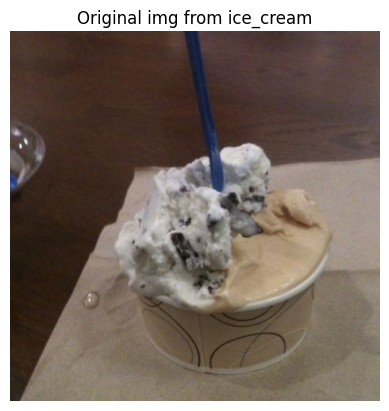

(569, 450, 3)


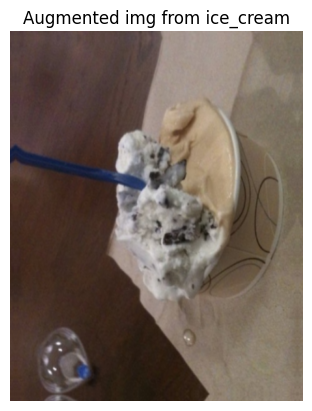

In [ ]:
img = mpimg.imread(random_img_path)
print(img.shape)
plt.imshow(img)
plt.title(f'Original img from {target_class}')
plt.axis(False)
plt.show()

img_aug = data_augmentation(img, training=True)
print(img_aug.shape)
plt.imshow((img_aug)/255.)
plt.title(f'Augmented img from {target_class}')
plt.axis(False)
plt.show()

## MODEL 1: Feature extraction -- 1%of data

In [ ]:
# Setup input shape and base model, freeze bose model's layers
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation as a layer
x = data_augmentation(inputs, training=True)

# Input aug. data to the base model
x = base_model(x, training=False)

# Pool
x = layers.GlobalAveragePooling2D()(x)

# Dense output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model
model_1 = keras.Model(inputs, outputs)

# compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model1_history = model_1.fit(train_data_1_percent,
                             epochs=5,
                             steps_per_epoch=len(train_data_1_percent),
                             validation_data=test_data,
                             validation_steps=0.25 * len(test_data),
                             callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                    experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230803-105647


Epoch 1/5
3/3 [==============================] - 34s 8s/step - loss: 2.3891 - accuracy: 0.1000 - val_loss: 2.2997 - val_accuracy: 0.1234
Epoch 2/5
3/3 [==============================] - 12s 5s/step - loss: 2.1350 - accuracy: 0.2571 - val_loss: 2.1703 - val_accuracy: 0.1969
Epoch 3/5
3/3 [==============================] - 10s 5s/step - loss: 1.9423 - accuracy: 0.3571 - val_loss: 2.0577 - val_accuracy: 0.2922
Epoch 4/5
3/3 [==============================] - 12s 6s/step - loss: 1.7800 - accuracy: 0.5429 - val_loss: 1.9645 - val_accuracy: 0.3219
Epoch 5/5
3/3 [==============================] - 12s 6s/step - loss: 1.5835 - accuracy: 0.6429 - val_loss: 1.8897 - val_accuracy: 0.4016


In [ ]:
results_1_persent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 29s 354ms/step - loss: 1.8895 - accuracy: 0.3712


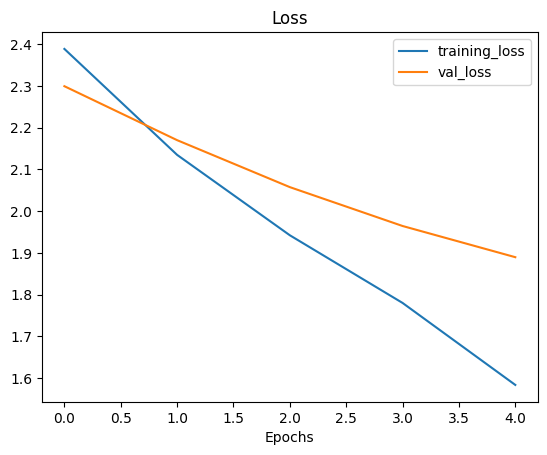

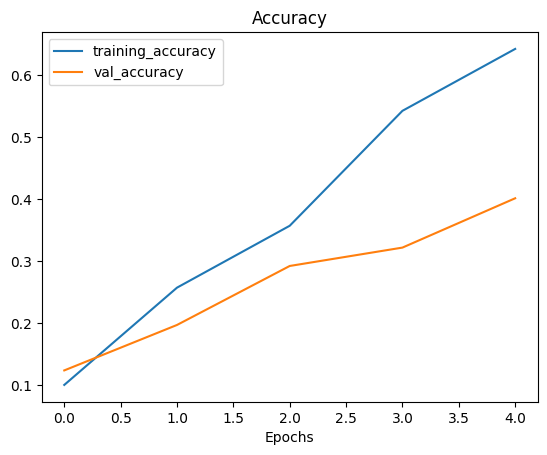

In [ ]:
plot_loss_curves(model1_history)

## Model 2 -- 10% of training data

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.image as mpimg
import os
import random
import matplotlib.pyplot as plt
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-08-04 09:04:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-04 09:04:35 (83.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# 10% of food dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data('10_food_classes_10_percent.zip')
walk_through_dir('10_food_classes_10_percent')

--2023-08-04 09:04:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 142.250.152.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   266MB/s    in 0.6s    

2023-08-04 09:04:36 (266 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food

In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
data_augmentation = keras. Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for ResNet model as they do not normalize by defualt
], name= "data_augmentation")

In [ ]:
# Setup input shape and base model, freeze bose model's layers
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# input
inputs = layers.Input(shape=input_shape, name="input_layer")

# prepare data
x = data_augmentation(inputs, training=True)

# x goes then into base_model
x = base_model(x, training=False)

# Pooling
x = layers.GlobalAveragePooling2D()(x)

# Dense
outputs = layers.Dense(10, activation="softmax")(x)

model_2 = keras.Model(inputs, outputs)


# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])


16705208/16705208 [==============================] - 0s 0us/step


# Model Checkpoint callback
tf.keras.callbacks.ModelCheckpoint()

In [ ]:
# Path
checkpoint_path = "ten_percent_model_checkpoint_weight/checkpoint.ckpt"

# Callback that saves model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

 Fit

In [ ]:
# Fit
initial_epochs = 5
model_2_history = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=0.25*len(test_data),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                    experiment_name="1_percent_data_aug"),
                                         checkpoint_callback])



Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230804-090926


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.8240
Epoch 1: val_loss improved from inf to 0.70865, saving model to ten_percent_model_checkpoint_weight/checkpoint.ckpt
24/24 [==============================] - 22s 846ms/step - loss: 0.6698 - accuracy: 0.8240 - val_loss: 0.7086 - val_accuracy: 0.7906
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.8427
Epoch 2: val_loss improved from 0.70865 to 0.67001, saving model to ten_percent_model_checkpoint_weight/checkpoint.ckpt
24/24 [==============================] - 18s 757ms/step - loss: 0.6137 - accuracy: 0.8427 - val_loss: 0.6700 - val_accuracy: 0.7969
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.8627
Epoch 3: val_loss did not improve from 0.67001
24/24 [==============================] - 17s 697ms/step - loss: 0.5567 - accuracy: 0.8627 - val_loss: 0.6701 - val_accuracy: 0.8172
Epoch 4/5
24/24 [=========================

In [ ]:
# evaluate
model_2.evaluate(test_data)

79/79 [==============================] - 25s 314ms/step - loss: 0.7453 - accuracy: 0.8024


[0.7452636957168579, 0.8023999929428101]

In [ ]:
 # evaluate
model_0.evaluate(test_data)

NameError: ignored

### Loading in checkpointed weights

In [ ]:
# Load saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)
# 79/79 [==============================] - 20s 250ms/step - loss: 0.6284 - accuracy: 0.8260

79/79 [==============================] - 24s 288ms/step - loss: 0.6273 - accuracy: 0.8232


In [ ]:
## Check if the loaded model results ARE CLOSE to the first, non-loaded model
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

# MODEL 3: FINE-TUNING an existing model on 10% training data

In [ ]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7a099f4df460> True
<keras.engine.sequential.Sequential object at 0x7a099f4dd9f0> True
<keras.engine.functional.Functional object at 0x7a099c61f6d0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7a099c5fe410> True
<keras.layers.core.dense.Dense object at 0x7a099c1e6260> True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# how many trainable variables are in teh basemodel?
print(len(model_2.layers[2].trainable_variables))

0


## Unfreeze some layers

In [ ]:
# first make all layers trainable:
base_model.trainable = True

# Freze all except the last ten
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (each time when we adjust the model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

# Check which label turned to be tunable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7a099f4df3d0> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7a099f4de0e0> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7a099f4de560> False
3 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7a099f4dff70> False
4 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7a099f5d06d0> False
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7a099f5d1a80> False
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7a099f5d2830> False
7 <keras.layers.core.activation.Activation object at 0x7a099f5d1b10> False
8 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7a099f5d34c0> False
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7a099f56c670> False
10 <keras.layers.core.activation.Activation object at 0x7a099f56d840> False
11 <keras.layers.pooling.global_average_pool

In [ ]:
# create fine-tune for anotehr 5 epochs
fine_tune_epochs = initial_epochs + 5

# refit the model (same as model_2, except there are more tunable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=model_2_history.epoch[-1],   # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune"),
                                                          ])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune/20230804-100813
Epoch 5/10
24/24 [==============================] - 26s 598ms/step - loss: 0.6813 - accuracy: 0.7680 - val_loss: 0.6459 - val_accuracy: 0.7697
Epoch 6/10
24/24 [==============================] - 17s 711ms/step - loss: 0.3092 - accuracy: 0.9040 - val_loss: 0.4895 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - 11s 459ms/step - loss: 0.1744 - accuracy: 0.9547 - val_loss: 0.6074 - val_accuracy: 0.8224
Epoch 8/10
24/24 [==============================] - 17s 697ms/step - loss: 0.1520 - accuracy: 0.9627 - val_loss: 0.4958 - val_accuracy: 0.8240
Epoch 9/10
24/24 [==============================] - 11s 430ms/step - loss: 0.0818 - accuracy: 0.9787 - val_loss: 0.5134 - val_accuracy: 0.8470
Epoch 10/10
24/24 [==============================] - 10s 427ms/step - loss: 0.0648 - accuracy: 0.9813 - val_loss: 0.6538 - val_accuracy: 0.8322


In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)
# WAS: 79/79 [==============================] - 20s 250ms/step - loss: 0.6284 - accuracy: 0.8260
# NOW: 79/79 [==============================] - 18s 208ms/step - loss: 0.6380 - accuracy: 0.8220

79/79 [==============================] - 18s 208ms/step - loss: 0.6380 - accuracy: 0.8220


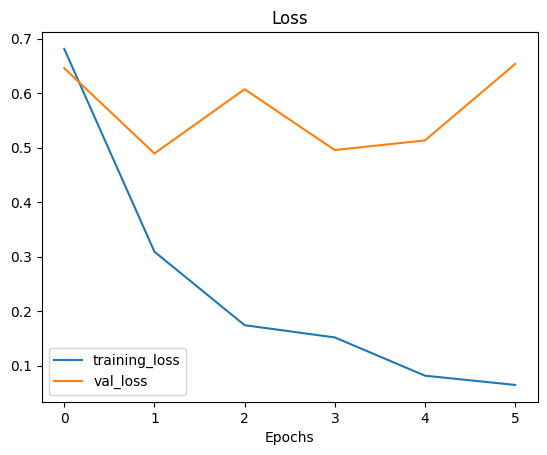

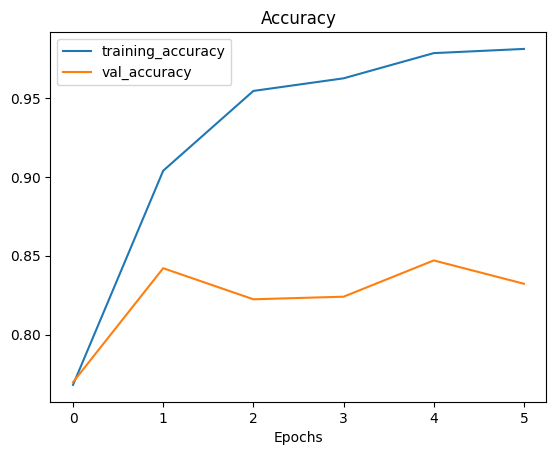

In [ ]:
# plot loss curves
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()



5
11
[0.8240000009536743, 0.8426666855812073, 0.862666666507721, 0.8733333349227905, 0.8826666474342346, 0.7680000066757202, 0.9039999842643738, 0.9546666741371155, 0.9626666903495789, 0.9786666631698608, 0.981333315372467]


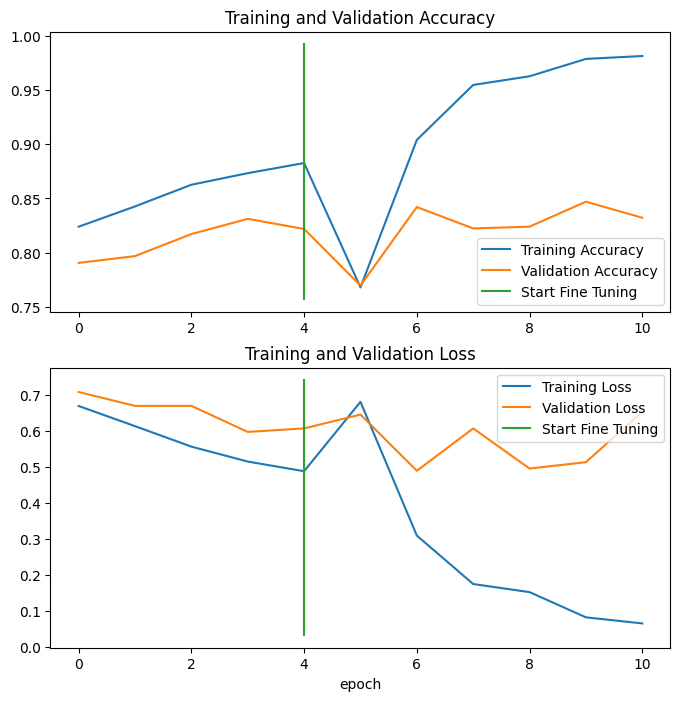

In [ ]:
compare_histories(original_history=model_2_history,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

# MODEL 4: Fine-tuning on the entire training data set

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

In [ ]:
unzip_data('10_food_classes_all_data.zip')
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [ ]:
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE,
                                                                                 batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.


In [ ]:
# revert the model to before the fine-tuning was introduce, this way will not be training model_2 across (10% data, then fine-tuning)
# to revert, first recompile into teh state as before:
# recompile model_2 to state it was prior to fine tuning as below:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ["accuracy"])

#then only load saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
model_2.evaluate(test_data)

79/79 [==============================] - 21s 219ms/step - loss: 0.6181 - accuracy: 0.8244


[0.6181369423866272, 0.824400007724762]

In [ ]:
model_2.summary()
# check layers of the model:
for layer in model_2.layers:
  print(layer, layer.trainable)
# how many trainable variables are in the basemodel?
print(len(model_2.layers[2].trainable_variables))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-trainab

In [ ]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])


In [ ]:
# fine-tune this model
fine_tune_epochsa = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=model_2_history.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune/20230804-110539
Epoch 5/10
235/235 [==============================] - 67s 242ms/step - loss: 0.6105 - accuracy: 0.8020 - val_loss: 0.4259 - val_accuracy: 0.8701
Epoch 6/10
235/235 [==============================] - 48s 200ms/step - loss: 0.4946 - accuracy: 0.8424 - val_loss: 0.4003 - val_accuracy: 0.8618
Epoch 7/10
235/235 [==============================] - 55s 233ms/step - loss: 0.4372 - accuracy: 0.8588 - val_loss: 0.3515 - val_accuracy: 0.8882
Epoch 8/10
235/235 [==============================] - 44s 186ms/step - loss: 0.3976 - accuracy: 0.8708 - val_loss: 0.3380 - val_accuracy: 0.8816
Epoch 9/10
235/235 [==============================] - 39s 164ms/step - loss: 0.3636 - accuracy: 0.8795 - val_loss: 0.3197 - val_accuracy: 0.9062
Epoch 10/10
235/235 [==============================] - 39s 162ms/step - loss: 0.3400 - accuracy: 0.8863 - val_loss: 0.3207 - val_accuracy: 0.8931


In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 12s 139ms/step - loss: 0.3312 - accuracy: 0.8976


5
11
[0.8240000009536743, 0.8426666855812073, 0.862666666507721, 0.8733333349227905, 0.8826666474342346, 0.8019999861717224, 0.8424000144004822, 0.8587999939918518, 0.8708000183105469, 0.8794666528701782, 0.8862666487693787]


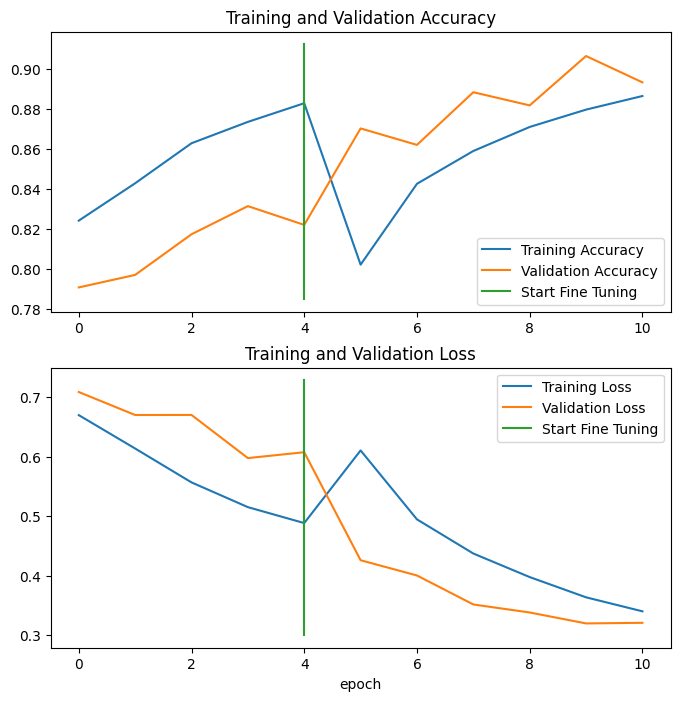

In [ ]:
compare_histories(original_history=model_2_history,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

# TensorBoard
the output https://tensorboard.dev/experiment/iKYlQ2vLRP2Ps9QjMMFwdA/#scalars

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
   --name "Transfer Learning Experiments with 10 Food101 Classes" \
   --description "Transfer learning experiments different in the amount of training data and fine-tuning applyied or not" \
   --one_shot # exists the uploader

In [ ]:
# the output https://tensorboard.dev/experiment/iKYlQ2vLRP2Ps9QjMMFwdA/#scalars


In [ ]:
# delete from tensorboard
!tensorboard dev list

2023-08-04 11:50:55.145526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/iKYlQ2vLRP2Ps9QjMMFwdA/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          Transfer learning experiments different in the amount of training data and fine-tuning applyied or not
	Id                   iKYlQ2vLRP2Ps9QjMMFwdA
	Created              2023-08-04 11:43:58 (6 minutes ago)
	Updated              2023-08-04 11:44:01 (6 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              132
	Tensor bytes         0
	Binary object bytes  3662994
https://tensorboard.dev/experiment/z2gQofWtRsKegODPf34jpg/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Compare two different TF Hub feature extraction architectures using 10% of the training data
	Id                   z2gQofWtRsKegODPf34jpg
	Created              2023-07-31 15:22:00
	Updated       